![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Machine Learning for Finance - Assignment 2

### by Amber Walker and Clarice Mottet
### All work was distributed and completed equally.

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.

1. **[Part 1: Backtesting trading strategies based on sentiment indicators.](#part1)**
- **Objective**: 
- **Tasks:**
    - tasks

2. **[Part 2: Factor Models and Sentiment](#part2)**
- **Objective**: Compare differences/similarities between factor models.
- **Tasks:**
    - Choose 9 stocks from the dataset dataset.rds using two consecutive years of data for experiments 2016-06 to 2018-06 (chosen and registered in Prob. 2 of sheet HW2 on the drive)
    - Compute the Robust (ellipsoid) Global Maximum Return Portfolio using as perturbation matrix Sigma (S) corresponding to the factor models:
      1. The Fama-French 3-factors returns 3FF
      2. The Sentiment indicator PNlog factor model
    - Try different kappas (at least 3 values in (0,1)) and multiple robust noisy solutions to check for sensitivity. Comment on the differences/similarities of results for both cases of Sigma.


## <a id='part0'>Part 0: Set Up</a>


In [9]:
#libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import cholesky
import scipy.linalg as la
import altair as alt
import yfinance as yfin  #These need lxml and this is deprecated
import pickle
import seaborn as sns

from numpy.linalg import solve, norm
from scipy.cluster.hierarchy import fcluster
from statsmodels.stats.correlation_tools import cov_nearest

current_directory = os.getcwd()

In [22]:
def log_return(df):
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)

def na_fill(df):
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")

def create_index(df):
    # the linear method already does ffill for the tail values
    return na_fill(df.mean(axis=1, skipna=False))

def cov2cor(df):
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), color='red', fontSize=14)
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), color='red', fontSize=14)
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()

## <a id='part0'>Part 1: Backtesting trading strategies based on sentiment indicators</a>

### Load and Clean Data


In [10]:
path_in_ = r'/Users/amberwalker/ML_Finance/MLF_HW2/Inputs/'
#clean sp500 data
sp500_df = pd.read_csv(path_in_ + 'SP500.csv')
sp500_df.drop(columns=['Unnamed: 0'], inplace=True)
sp500_df.columns = sp500_df.columns.str.lower().str.strip()
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df.set_index('date', inplace=True)

print(sp500_df.head())
print(sp500_df.isna().sum()) #no missing data

#load disney data
dis_df = pd.read_csv(path_in_ + 'DIS.csv')
dis_df.drop(columns=['Unnamed: 0'], inplace=True)
dis_df.columns = dis_df.columns.str.lower().str.strip()
dis_df['date'] = pd.to_datetime(dis_df['date'])

print(dis_df.head())
dis_nulls = dis_df.isna().sum()
print(dis_nulls)

                   open         high          low        close    adj close  \
date                                                                          
2019-09-03  2909.010010  2914.389893  2891.850098  2906.270020  2906.270020   
2019-09-04  2924.669922  2938.840088  2921.860107  2937.780029  2937.780029   
2019-09-05  2960.600098  2985.860107  2960.600098  2976.000000  2976.000000   
2019-09-06  2980.330078  2985.030029  2972.510010  2978.709961  2978.709961   
2019-09-09  2988.429932  2989.429932  2969.389893  2978.429932  2978.429932   

                volume downloadeddate     rvt  positivepartscr  \
date                                                             
2019-09-03  3426790000     2019-09-03  0.0142           0.0043   
2019-09-04  3163260000     2019-09-04  0.0107           0.0061   
2019-09-05  3890700000     2019-09-05  0.0056           0.0110   
2019-09-06  3208280000     2019-09-06  0.0194           0.0073   
2019-09-09  4002890000     2019-09-09  0.0041     

#### Fill missing values
Since there are some missing values in the Disney dataset, we'll use foward fill the values (as this makes the most sense with time series data and sentiment scores)

In [11]:

dis_df.sort_values(by='date', inplace=True)
dis_df.set_index('date', inplace=True)
dis_df.fillna(method='ffill', inplace=True) #foward fill
dis_df.fillna(method='bfill', inplace=True) #back fill in case we still have missing values

dis_nulls = dis_df.isna().sum()
print(dis_nulls)

open                  0
high                  0
low                   0
close                 0
adj close             0
volume                0
rvt                   0
positivepartscr       0
negativepartscr       0
fearpartscr           0
findownpartscr        0
finuppartscr          0
finhypepartscr        0
certaintypartscr      0
uncertaintypartscr    0
dtype: int64


/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/3052566279.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dis_df.fillna(method='ffill', inplace=True) #foward fill
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/3052566279.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dis_df.fillna(method='bfill', inplace=True) #back fill in case we still have missing values


### Calculate Sentiment & Volume-Weighted Indicators
- Compute BULL and BEAR indicators
- Weight BULL and BEAR by RVT.




In [12]:
#function to build sentiment indicators for each dataset
#code borrowed from "Lab6_TradingStrategywCost.ipynb"
def build_indicators(df):
    # Bearish sentiment indicators
    negativeP = df['negativepartscr']
    uncertaintyP = df['uncertaintypartscr']
    findownP = df['findownpartscr']

    # Bullish sentiment indicators
    positiveP = df['positivepartscr']
    certaintyP = df['certaintypartscr']
    finupP = df['finuppartscr']

    BULL = 0.2*(positiveP) + 0.2*(certaintyP) + .8*(finupP)
    BEAR = 0.2*(negativeP) + 0.2*(uncertaintyP) + .8*(findownP)

    # Calculate Volume-Weighted Sentiment Indicators
    total_volume = df['volume'].sum()
    df['vw_bull'] = (BULL * df['volume']) / total_volume
    df['vw_bear'] = (BEAR * df['volume']) / total_volume

    # Calculate Bull-Bear Ratio (BBr)
    BULL_BEAR = BULL + BEAR
    BULL_BEAR[BULL_BEAR == 0] = np.nan
    BBr = 100 * BULL / BULL_BEAR
    BBr.fillna(method='ffill', inplace=True)
    BBr.fillna(method='bfill', inplace=True)
    df['BBr'] = BBr

    # Calculate Positive-Negative Log Ratio (PNlog)
    df['PNlog'] = np.log((df['positivepartscr'] + 1) / (df['negativepartscr'] + 1))

    return df

sp500_df = build_indicators(sp500_df).copy()
dis_df = build_indicators(dis_df).copy()

print(sp500_df.head())
print(dis_df.head())

                   open         high          low        close    adj close  \
date                                                                          
2019-09-03  2909.010010  2914.389893  2891.850098  2906.270020  2906.270020   
2019-09-04  2924.669922  2938.840088  2921.860107  2937.780029  2937.780029   
2019-09-05  2960.600098  2985.860107  2960.600098  2976.000000  2976.000000   
2019-09-06  2980.330078  2985.030029  2972.510010  2978.709961  2978.709961   
2019-09-09  2988.429932  2989.429932  2969.389893  2978.429932  2978.429932   

                volume downloadeddate     rvt  positivepartscr  \
date                                                             
2019-09-03  3426790000     2019-09-03  0.0142           0.0043   
2019-09-04  3163260000     2019-09-04  0.0107           0.0061   
2019-09-05  3890700000     2019-09-05  0.0056           0.0110   
2019-09-06  3208280000     2019-09-06  0.0194           0.0073   
2019-09-09  4002890000     2019-09-09  0.0041     

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/4066212104.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr.fillna(method='ffill', inplace=True)
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/4066212104.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr.fillna(method='bfill', inplace=True)
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/4066212104.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr.fillna(method='ffill', inplace=True)
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_57759/4066212104.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr.f

### Performance Metrics


In [13]:
def performance(x, ntrades=1, cost=0):
    if len(x) == 0:
        return pd.Series([np.nan] * 8, index=["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
                                              "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"], name=x.name)

    cumRetx = np.cumsum(x, axis=0) - ntrades * cost
    print("Cumulative Returns:", cumRetx)  # Debugging step

    if len(cumRetx) == 0 or cumRetx.iloc[-1] + 1 <= 0:
        print("Invalid cumulative returns for annual return calculation.")
        return pd.Series([np.nan] * 8, index=["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
                                              "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"], name=x.name)

    annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1) if cumRetx.iloc[-1] + 1 > 0 else np.nan
    print("Annual Return:", annRetx)  # Debugging step

    sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252) if np.std(x, ddof=1) > 0 else np.nan
    print("Annualized Sharpe Ratio:", sharpex)  # Debugging step

    winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x) if np.count_nonzero(x) > 0 else np.nan
    print("Win Percentage:", winpctx)  # Debugging step

    annSDx = np.std(x, ddof=1) * np.sqrt(252) if np.std(x, ddof=1) > 0 else np.nan
    print("Annualized Volatility:", annSDx)  # Debugging step

    DDs = np.minimum.accumulate(cumRetx) - cumRetx
    maxDDx = DDs.min() if len(DDs) > 0 else np.nan
    maxLx = (cumRetx == DDs).argmax() if len(cumRetx) > 0 and len(DDs) > 0 else np.nan

    print("Maximum Drawdown:", maxDDx)  # Debugging step
    print("Max Length Drawdown:", maxLx)  # Debugging step

    Perf = np.array([cumRetx.iloc[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
    names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
                      "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
    return pd.Series(Perf, index=names, name=x.name)

## Generate Trading Signals and Backtest the Strategy
Here we build the logic to generate buy/sell signals based on the volume-weighted sentiment indicators and backtest the strategy.



In [14]:
def vw_sentiment_strategy(df, bull_threshold, bear_threshold, long_only=True):
    #signals set to 0 (no position)
    df['signal'] = 0

    if long_only:
        #long-only strategy: Buy when either vw_bull or BBr are above their respective thresholds
        df.loc[(df['vw_bull'] > df['vw_bull'].quantile(bull_threshold)) | 
               (df['BBr'] > df['BBr'].quantile(bear_threshold)), 'signal'] = 1
    else:
        #long-short strategy: 
        # short when BBr is above the bull_threshold
        df.loc[df['BBr'] > df['BBr'].quantile(bull_threshold), 'signal'] = -1
        #buy when PNlog or vw_bull are above thresholds
        df.loc[(df['PNlog'] > df['PNlog'].quantile(bear_threshold)) | (df['vw_bull'] > df['vw_bull'].quantile(bear_threshold)), 'signal'] = 1

    return df

### Test Strategy w/ Rolling Window

In [15]:
def rolling_test_vw_strategy(df, bull_threshold, bear_threshold, w_size=127, long_only=True):
    df = vw_sentiment_strategy(df, bull_threshold, bear_threshold, long_only=long_only)
    df['daily_return'] = df['close'].pct_change()
    df['signal'] = df['signal'].shift(1).fillna(0)
    df['strategy_return'] = df['signal'] * df['daily_return']

    if df['strategy_return'].isna().all():
        return {"AvgPerf": pd.DataFrame(), "NumWindows": 0, "CumulativeReturns": None}

    bmk_returns = df['daily_return'].rename("BH")
    my_returns = df['strategy_return'].rename("VWx")
    tt = pd.concat([my_returns, bmk_returns], axis=1).dropna()

    if tt.empty:
        return {"AvgPerf": pd.DataFrame(), "NumWindows": 0, "CumulativeReturns": None}

    n_windows = int(tt.shape[0] - w_size)
    if n_windows < 1:
        raise ValueError("Window size too large. Consider reducing the window size or increasing the dataset length.")

    perform = []
    for i in range(n_windows):
        bh_stra = tt.iloc[i:w_size + i, 1]
        my_stra = tt.iloc[i:w_size + i, 0]
        perform.append([bh_stra.mean(), my_stra.mean()])

    perform = np.array(perform)

    if perform.shape[0] == 0:
        return {"AvgPerf": pd.DataFrame(), "NumWindows": 0, "CumulativeReturns": None}

    bh_means = perform[:, 0].mean()
    me_means = perform[:, 1].mean()
    mean_perf = np.array([bh_means, me_means])
    mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])

    cumulative_returns = tt

    return {"AvgPerf": mean_perf, "NumWindows": n_windows, "CumulativeReturns": cumulative_returns}


### Tune Parameters of Strategy

Here we tune the threshold parameters. The thresholds that give us excess return (Me - BH) are the best.

Disney Long-Only with bull_threshold=0.1, bear_threshold=0.1: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.1: Negative
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.2: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.2: Negative
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.3: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.3: Negative
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.4: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.4: Negative
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.5: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.5: Positive
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.6: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.6: Negative
Disney Long-Only with bull_threshold=0.1, bear_threshold=0.7: Negative
Disney Long-Short with bull_threshold=0.1, bear_threshold=0.7: Negative

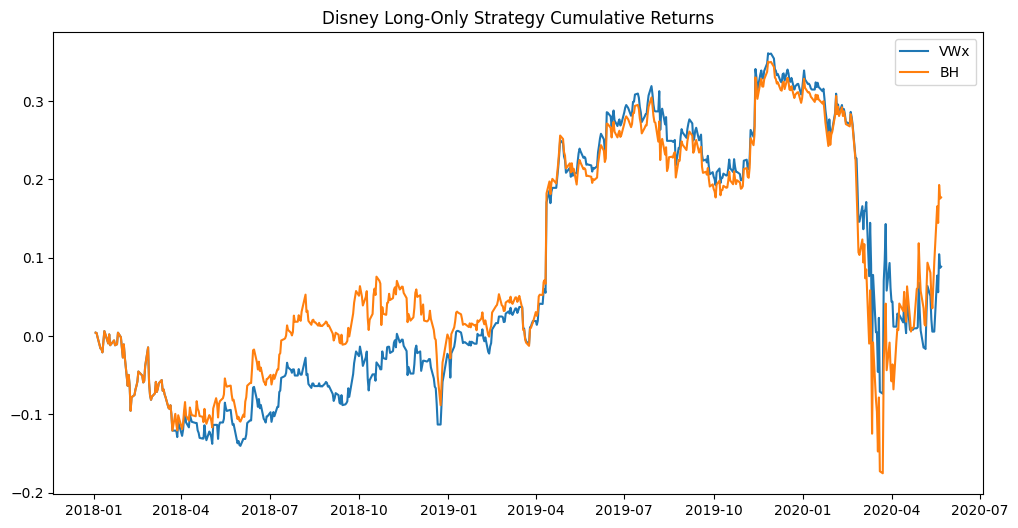

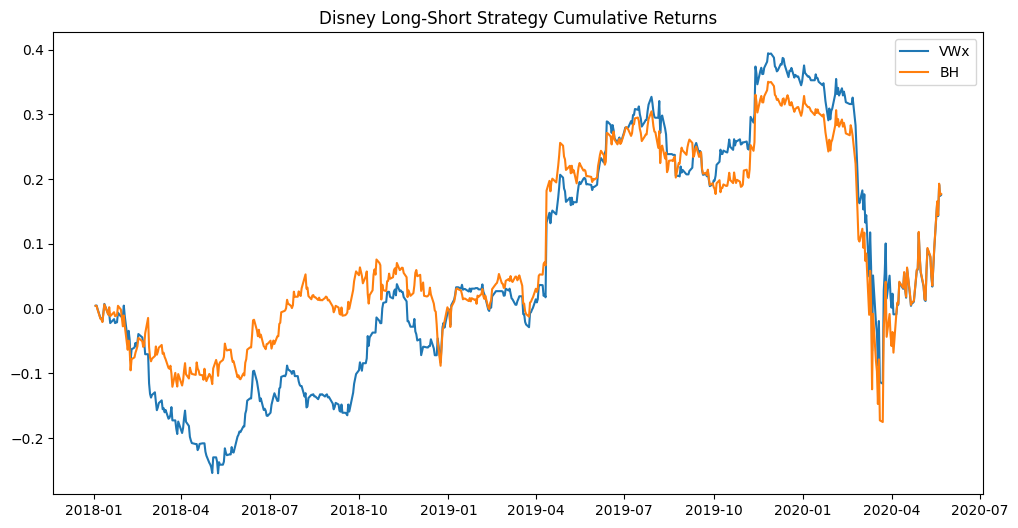

S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.1: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.1: Positive
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.2: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.2: Negative
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.3: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.3: Negative
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.4: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.4: Negative
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.5: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.5: Negative
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.6: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold=0.6: Negative
S&P 500 Long-Only with bull_threshold=0.1, bear_threshold=0.7: Positive
S&P 500 Long-Short with bull_threshold=0.1, bear_threshold

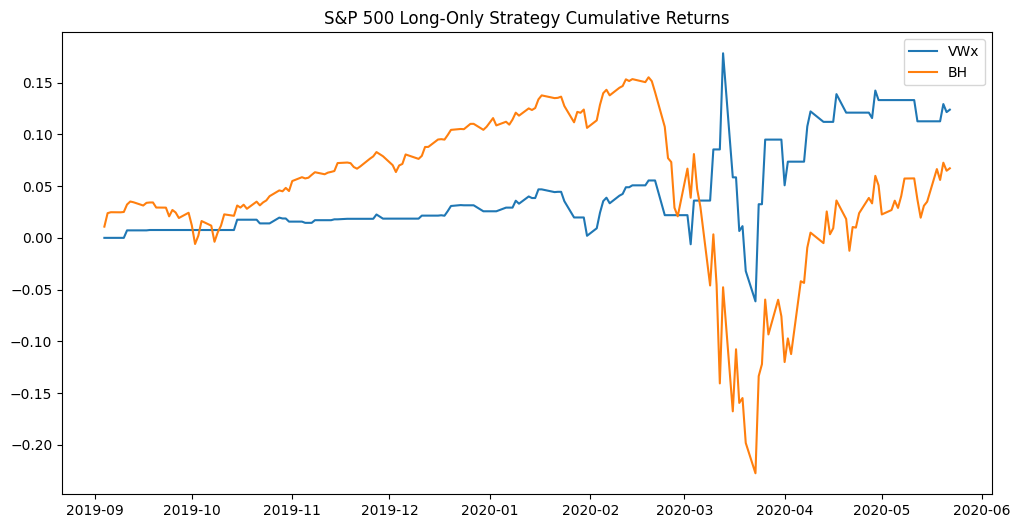

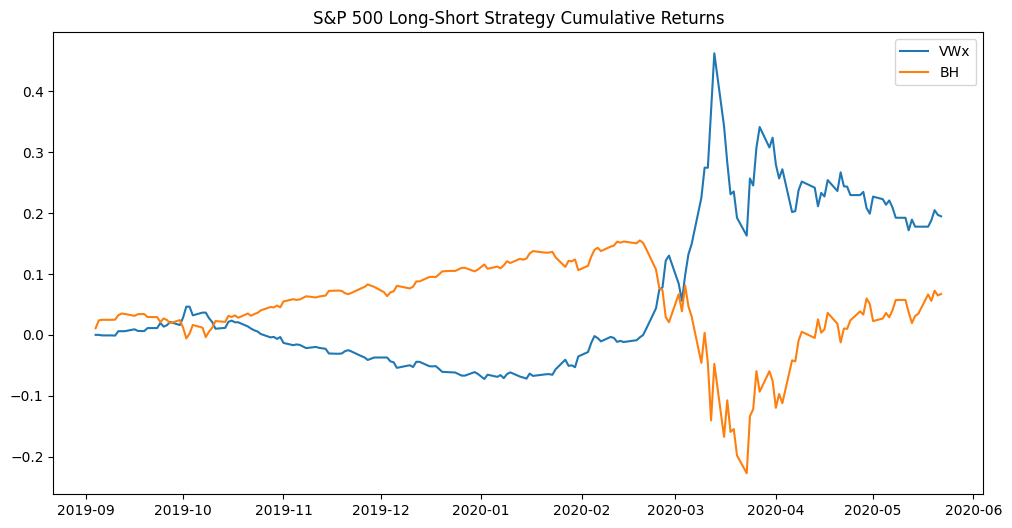

In [17]:
import itertools
bull_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bear_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = list(itertools.product(bull_thresholds, bear_thresholds))

#function to print if excess return is positive
def check_excess_return(avg_perf_me, avg_perf_bh):
    excess_return = avg_perf_me - avg_perf_bh
    is_positive = "Positive" if excess_return > 0 else "Negative"
    return is_positive

#function to perform the grid search
def perform_grid_search(df, name, w_size):
    best_params_long = None
    best_perf_long = -np.inf
    best_cumulative_returns_long = None

    best_params_long_short = None
    best_perf_long_short = -np.inf
    best_cumulative_returns_long_short = None

    for bull_threshold, bear_threshold in param_grid:
        result_long = rolling_test_vw_strategy(df, bull_threshold, bear_threshold, w_size=w_size, long_only=True)
        if not result_long["AvgPerf"].empty:
            avg_perf_me = result_long['AvgPerf'].loc['Me', 'AvgPerf']
            avg_perf_bh = result_long['AvgPerf'].loc['BH', 'AvgPerf']
            excess_return = avg_perf_me - avg_perf_bh
            print(f"{name} Long-Only with bull_threshold={bull_threshold}, bear_threshold={bear_threshold}: {check_excess_return(avg_perf_me, avg_perf_bh)}")

            if excess_return > 0 and avg_perf_me > best_perf_long:
                best_perf_long = avg_perf_me
                best_params_long = (bull_threshold, bear_threshold)
                best_cumulative_returns_long = result_long['CumulativeReturns']

        result_long_short = rolling_test_vw_strategy(df, bull_threshold, bear_threshold, w_size=w_size, long_only=False)
        if not result_long_short["AvgPerf"].empty:
            avg_perf_me = result_long_short['AvgPerf'].loc['Me', 'AvgPerf']
            avg_perf_bh = result_long_short['AvgPerf'].loc['BH', 'AvgPerf']
            excess_return = avg_perf_me - avg_perf_bh
            print(f"{name} Long-Short with bull_threshold={bull_threshold}, bear_threshold={bear_threshold}: {check_excess_return(avg_perf_me, avg_perf_bh)}")

            if excess_return > 0 and avg_perf_me > best_perf_long_short:
                best_perf_long_short = avg_perf_me
                best_params_long_short = (bull_threshold, bear_threshold)
                best_cumulative_returns_long_short = result_long_short['CumulativeReturns']

    print(f"Best parameters for {name} Long-Only: {best_params_long}")
    print(f"Best performance for {name} Long-Only: {best_perf_long}")

    print(f"Best parameters for {name} Long-Short: {best_params_long_short}")
    print(f"Best performance for {name} Long-Short: {best_perf_long_short}")

    # Plot the best cumulative returns for Long-Only
    if best_cumulative_returns_long is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(np.cumsum(best_cumulative_returns_long['VWx'], axis=0), label='VWx')
        plt.plot(np.cumsum(best_cumulative_returns_long['BH'], axis=0), label='BH')
        plt.legend()
        plt.title(f'{name} Long-Only Strategy Cumulative Returns')
        plt.show()

    # Plot the best cumulative returns for Long-Short
    if best_cumulative_returns_long_short is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(np.cumsum(best_cumulative_returns_long_short['VWx'], axis=0), label='VWx')
        plt.plot(np.cumsum(best_cumulative_returns_long_short['BH'], axis=0), label='BH')
        plt.legend()
        plt.title(f'{name} Long-Short Strategy Cumulative Returns')
        plt.show()

    return best_params_long, best_params_long_short


# Perform grid search for Disney dataset
best_params_dis_long, best_params_dis_long_short = perform_grid_search(dis_df, "Disney", w_size=127)

# Perform grid search for S&P 500 dataset
best_params_sp500_long, best_params_sp500_long_short = perform_grid_search(sp500_df, "S&P 500", w_size=127)

In [18]:
def print_best_performance(df, best_params, long_only=True):
    bull_threshold, bear_threshold = best_params
    
    # Test the strategy with the best parameters
    result = rolling_test_vw_strategy(df, bull_threshold, bear_threshold, w_size=127, long_only=long_only)
    
    if 'CumulativeReturns' not in result:
        print("CumulativeReturns not found in the result.")
        return
    
    # Extract the returns
    cumulative_returns = result['CumulativeReturns']
    myReturns = cumulative_returns['VWx']
    bmkReturns = cumulative_returns['BH']
    
    # Calculate performance metrics
    strategy_perf = performance(myReturns)
    benchmark_perf = performance(bmkReturns)
    
    # Print the performance metrics
    print(f"Performance Metrics for {'Long-Only' if long_only else 'Long-Short'} Strategy with Best Parameters:")
    print(strategy_perf)
    print("\nBenchmark Performance Metrics:")
    print(benchmark_perf)

# Print performance metrics for Disney dataset
print_best_performance(dis_df, best_params_dis_long, long_only=True)
print_best_performance(dis_df, best_params_dis_long_short, long_only=False)

# Print performance metrics for S&P 500 dataset
print_best_performance(sp500_df, best_params_sp500_long, long_only=True)
print_best_performance(sp500_df, best_params_sp500_long_short, long_only=False)

Cumulative Returns: date
2018-01-03    0.004293
2018-01-04    0.003848
2018-01-05   -0.001587
2018-01-08   -0.015922
2018-01-09   -0.016649
                ...   
2020-05-18    0.077142
2020-05-19    0.055918
2020-05-20    0.104445
2020-05-21    0.087016
2020-05-22    0.088629
Name: VWx, Length: 601, dtype: float64
Annual Return: 0.036248068649781695
Annualized Sharpe Ratio: 29.818400754283086
Win Percentage: 0.510989010989011
Annualized Volatility: 0.306338135804715
Maximum Drawdown: -0.5014583282568795
Max Length Drawdown: 0
Cumulative Returns: date
2018-01-03    0.004293
2018-01-04    0.003848
2018-01-05   -0.001587
2018-01-08   -0.015922
2018-01-09   -0.016649
                ...   
2020-05-18    0.165637
2020-05-19    0.144414
2020-05-20    0.192940
2020-05-21    0.175512
2020-05-22    0.177125
Name: BH, Length: 601, dtype: float64
Annual Return: 0.07076932696414429
Annualized Sharpe Ratio: 55.37959487255556
Win Percentage: 0.5183333333333333
Annualized Volatility: 0.3220296290719

## <a id='part2'>Part 2: Factor Models and Sentiment</a>
- **Objective**: Compare differences/similarities between factor models
- **Tasks:**
    - Choose 9 stocks from the dataset dataset.rds using two consecutive years of data for experiments 2016-06 to 2018-06 (chosen and registered in Prob. 2 of sheet HW2 on the drive)
    - Create function code for the Robust (ellipsoid) Global Maximum Return Portfolio using as perturbation matrix Sigma (S) corresponding to the factor models:
      1. The Fama-French 3-factors returns 3FF
      2. The Sentiment indicator PNlog factor model
    - Try different kappas (at least 3 values in (0,1)) and multiple robust noisy solutions to check for sensitivity using the two different factor models. Comment on the differences/similarities of results for both cases of Sigma.

- Choose 9 stocks from the dataset dataset.rds using two consecutive years of data for experiments 2016-06 to 2018-06 (chosen and registered in Prob. 2 of sheet HW2 on the drive)

In [23]:
#-----------------------------------------
#Import in Stocks

dataset = pd.read_pickle(f'{current_directory}/Inputs/dataset.pkl')

#Subset to 9 stocks
#Subset to time frame 2016-06 to 2018-06

keep_stocks = ['AAPL', 'ABBV', 'AMZN', 'DIS', 'HSBC', 'JPM', 'MCD', 'MSFT', 'XOM']

# print(dataset['BBr'].columns)

for key in dataset.keys():
    dataset[key] = dataset[key][keep_stocks]
    dataset[key] = dataset[key][(dataset[key].index >= pd.to_datetime('2016-06-01'))&(dataset[key].index < pd.to_datetime('2018-06-01'))]

#-----------------------------------------
#Import in Fama-French factors

fama_lib = pd.read_csv(f'{current_directory}/Inputs/F-F_Research_Data_Factors_daily.CSV', skiprows=4, skipfooter=1, index_col=0, engine='python')
fama_lib.index = pd.to_datetime(fama_lib.index, format="%Y%m%d")
fama_lib = fama_lib.iloc[:, 0:3] # We only use the first 3 columns

#-----------------------------------------
# Prepare stock data

stockPrices = dataset["adjusted"]
X = log_return(stockPrices)
T, N = X.shape  # nrow and ncol

F_FamaFrench = fama_lib.loc[X.index]/100   # Fama-French factors
BBrMkt = create_index(dataset["BBr"])/100  # BBr Market index
PNlogMkt = create_index(dataset["PNlog"])  # PNlog Market index
SentIndx = PNlogMkt.loc[X.index]           # Sentiment index

# split data into training and test data
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]

F_FamaFrench_trn = F_FamaFrench.iloc[0:T_trn, ]
F_FamaFrench_tst = F_FamaFrench.iloc[T_trn:T, ]

SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]


- Create function code for the Robust (ellipsoid) Global Maximum Return Portfolio using as perturbation matrix Sigma (S) corresponding to the factor models:
    1. The Fama-French 3-factors returns 3FF
    2. The Sentiment indicator PNlog factor model

In [24]:
#Functions

def portfolioMaxReturnRobustEllipsoid(mu_hat, S, kappa, color, note_method):
    mu_hat = np.array(mu_hat)
    S12 = la.cholesky(S)  # S12.T @ S12 = Sigma
    w = cp.Variable(len(mu_hat))
    prob = cp.Problem(cp.Maximize(mu_hat @ w - kappa * cp.norm(S12 @ w, p=2)), constraints=[w >= 0, sum(w) == 1])
    result = prob.solve()

    w_GMRP_robust_df = pd.DataFrame(w.value)
    w_GMRP_robust_df['stock'] = keep_stocks
    w_GMRP_robust_df.columns = ['w', 'stock']

    chart = alt.Chart(w_GMRP_robust_df).mark_bar(size=12, color=color).encode(
        x='stock:N',
        y='w:Q'
    ).properties(width=125, title=f'Portfolilo Weight: Factor-{note_method}, kappa-{kappa}')
    # chart.show()

    return w.value, chart

def fama_french_3F(X_trn):
    F = F_FamaFrench_trn.copy()
    F.insert(0, 'ones', 1)
    Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3"])
    alpha = Gamma["alpha"]
    B = Gamma[["beta1", "beta2", "beta3"]]
    E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
    PsiFF = (E.T @ E) / (T_trn - 4)
    Sigma_FamaFrench = B.to_numpy() @ F_FamaFrench_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFF))
    return Sigma_FamaFrench

def sentiment_ind(X_trn):
    F = SentIndx_trn.copy().to_frame()
    F.insert(0, 'ones', 1)
    Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta"])
    alpha = Gamma["alpha"]
    beta = Gamma["beta"]
    E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
    Psi_Sent = (E.T @ E) / (T_trn - 2)
    Sigma_SentInx = SentIndx_trn.var() * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
    return Sigma_SentInx

def is_pos_def(x, epsilon):
    return np.all(np.linalg.eigvals(x) > epsilon)

def add_noise(mu, Sigma, w_GMRP_robust, kappa, color, note_method):

    w_all_GMRP_robust_ellipsoid = np.expand_dims(w_GMRP_robust, axis=1)

    #multiple robust solutions
    np.random.seed(100)
    for i in range(6):
        X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma, size=T))
        mu_noisy = X_noisy.mean(axis=0)
        Sigma_noisy = X_noisy.cov()
        # Sigma_noisy = factor_method(X_noisy)
        if not is_pos_def(Sigma_noisy, 0.001):
            Sigma_noisy = cov_nearest(Sigma_noisy)
        w_GMRP_robust_ellipsoid_noisy, chart = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa, color, note_method)
        w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                    np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

    w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
    w_all_GMRP_robust_ellipsoid["stock"] = keep_stocks

    long_w_all_GMRP_robust_ellipsoid = pd.melt(
        w_all_GMRP_robust_ellipsoid,
        id_vars=['stock'],
        var_name='run',
        value_name='weight')

    chart = alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color=color).encode(
        x=alt.X('run:O', axis=None),
        y='weight:Q',
        column=alt.Column('stock:N', spacing=2)
    ).properties(width=125, title=f'Portfolilo Weight with Noise: Factor-{note_method}, kappa-{kappa}')

    chart.show()

    return


In [25]:
Sigma_true = X_tst.cov()

ntype = "fro"  # Frobenious
error = pd.DataFrame({
    "SCM": norm(X_trn.cov().to_numpy() - Sigma_true.to_numpy(), ord=ntype),
    "FamaFrench": norm(fama_french_3F(X_trn) - Sigma_true.to_numpy(), ord=ntype),
    "SentInd": norm(sentiment_ind(X_trn) - Sigma_true.to_numpy(), ord=ntype)
}, index=[0])

order = ["SCM", "FamaFrench", "SentInd"]
alt.Chart(error.melt(value_name='error')).mark_bar().encode(
    x = alt.X('variable', title='', axis=alt.Axis(labelAngle=0), sort=order),
    y = 'error',
    color = alt.value("mediumaquamarine")
).properties(
    title="Error in Estimation of Covariance Matrix",
    height=300,
    width=400
)


alt.Chart(...)

- Try different kappas (at least 3 values in (0,1)) and multiple robust noisy solutions to check for sensitivity using the two different factor models. Comment on the differences/similarities of results for both cases of Sigma.

For our analysis we've chosen our $\kappa$ values to be 0.1 representing a very risk-averse return estimate, 0.7 a less risk-averse but still moderate and 0.9 representing a very risk-tolerate return estimate.

Fama-French-3F: We see for the lower $\kappa$ value at 0.1, the best stocks to maximize portfolio returns in a conservative approach is AMZN, APPL, MKST. We see for the risk-tolerate moderate and aggressive $\kappa$ values give similar stock suggestions of DIS and MCD. Even with noise incorporated, we see similar stock suggestions to maximize returns respective to $\kappa$. What is interesting is that more risk-tolerant $\kappa$ values lead to suggestions of including more stocks in the portfolio than a conservative approach.

Sent-Ind-PNlog: For low-risk $\kappa$ value 0.1 we see AMZN, MKST, APPL as the suggestions for maximizing returns, for the more risk and moderate and high-risk $\kappa$ values we see DIS, MCD and MKST. With noise, we see for the low-risk $\kappa$ that MKST emerges ahead of AMZN as the stock to best maximize returns and for the other $\kappa$ values we see MCD and DIS as the leads and not so much MKST.

In comparison of the two factor models, we see similar results for the $\kappa \text{=0.1}$ but for the higher $\kappa$ values the difference really emerges with regard to MKST. The Fama-French-3F factor model did not indicate MKST for a higher risk approach and while the Sentiment Indicator factor model did. What is interesting is that with noise included MSKT no longer ends up as a suggestion to maximize returns. We see that Fama-French-3F gives a more decisive portfolio composition because we see strong indication of what main stocks should be included (two stocks at over 25% each) whereas with Sentiment Indicator, the portfolio contains all stocks and the two highest weights are only over 14%.

We don't see a big difference in results without or with noise using the Fama-French-3F factor model but we do see differences in results between the not noisy or noisy Sentiment Indicator results meaning the Sentiment Indicator factor model may not be a very stable method to use. 

In [26]:
kappa_vals = [0.1, 0.7, 0.9]
dict_track = {}

- Fama French 3-Factor

In [27]:
#fama_french_3F

note_method = 'FamaFrench3F'
color = 'lightblue'
mu = X.mean(axis=0)
Sigma = fama_french_3F(X_trn)
charts = []

for kappa in kappa_vals:
    w_GMRP_robust, chart = portfolioMaxReturnRobustEllipsoid(mu, Sigma, kappa, color, note_method)
    ref = (note_method, kappa)
    dict_track[ref] = w_GMRP_robust
    charts.append(chart)

display(alt.hconcat(*charts))


alt.HConcatChart(...)

In [28]:
#fama_french_3F with noise

note_method = 'FamaFrench3F'
color = 'lightblue'
mu = X.mean(axis=0)
Sigma = fama_french_3F(X_trn)

for kappa in kappa_vals:
    ref = (note_method, kappa)
    add_noise(mu, Sigma, dict_track[ref], kappa, color, note_method)


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

- Sentiment Indicator

In [29]:
#Sentiment indicator

note_method = 'SentInd'
color = 'lightgreen'
mu = X.mean(axis=0)
Sigma = sentiment_ind(X_trn)
charts = []

for kappa in kappa_vals:
    w_GMRP_robust, chart = portfolioMaxReturnRobustEllipsoid(mu, Sigma, kappa, color, note_method)
    ref = (note_method, kappa)
    dict_track[ref] = w_GMRP_robust
    charts.append(chart)

display(alt.hconcat(*charts))

alt.HConcatChart(...)

In [30]:
#Sentiment indicator with noise

note_method = 'SentInd'
color = 'lightgreen'
mu = X.mean(axis=0)
Sigma = sentiment_ind(X_trn)

for kappa in kappa_vals:
    ref = (note_method, kappa)
    add_noise(mu, Sigma, dict_track[ref], kappa, color, note_method)


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)